<a href="https://colab.research.google.com/github/thedenaas/jub_ml/blob/main/fall_2022/seminar_4/seminar4_torch_tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import math
import numpy as np
import time

import matplotlib.pyplot as plt
% matplotlib inline
from IPython.display import set_matplotlib_formats

from tqdm.notebook import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt

## The Basics of PyTorch


In [4]:
import torch

### Tensors

Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more on that later).
The name "tensor" is a generalization of concepts you already know. For instance, a vector is a 1-D tensor, and a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, we can convert most tensors to numpy arrays (and back) but we don't need it too often.

#### Initialization



* `torch.zeros`: Creates a tensor filled with zeros
* `torch.ones`: Creates a tensor filled with ones
* `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$
* `torch.Tensor` (input list): Creates a tensor from the list elements you provide

In [5]:
# Create a tensor from a (nested) list
x = torch.Tensor([[1, 2], [3, 4]])
print(x)

tensor([[1., 2.],
        [3., 4.]])


In [6]:
# Create a tensor with random values between 0 and 1 with the shape [2, 3, 4]
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.9767, 0.2283, 0.6040, 0.0992],
         [0.5396, 0.8151, 0.8230, 0.1056],
         [0.6414, 0.9968, 0.3314, 0.1188]],

        [[0.1029, 0.0012, 0.0705, 0.3076],
         [0.0416, 0.9222, 0.9345, 0.3293],
         [0.7888, 0.5234, 0.7389, 0.5183]]])


You can obtain the shape of a tensor in the same way as in numpy (`x.shape`), or using the `.size` method:

In [9]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


#### Tensor to Numpy, and Numpy to Tensor

Tensors can be converted to numpy arrays, and numpy arrays back to tensors. To transform a numpy array into a tensor, we can use the function `torch.from_numpy`:

In [10]:
np_arr = np.array([[1, 2], [3, 4]])
tensor = torch.from_numpy(np_arr)  # torch.Tensor(np_arr)

print("Numpy array:", np_arr)
print("PyTorch tensor:", tensor)

Numpy array: [[1 2]
 [3 4]]
PyTorch tensor: tensor([[1, 2],
        [3, 4]], dtype=torch.int32)


To transform a PyTorch tensor back to a numpy array, we can use the function `.numpy()` on tensors:

In [11]:
tensor = torch.arange(4)
np_arr = tensor.numpy()

print("PyTorch tensor:", tensor)
print("Numpy array:", np_arr)

PyTorch tensor: tensor([0, 1, 2, 3])
Numpy array: [0 1 2 3]


The conversion of tensors to numpy require the tensor to be on the CPU, and not the GPU. In case you have a tensor on GPU, you need to call `.cpu()` on the tensor beforehand. Hence, you get a line like `np_arr = tensor.cpu().numpy()`.

#### Operations

Most operations that exist in numpy, also exist in PyTorch. A full list of operations can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#), but we will review the most important ones here.

The simplest operation is to add two tensors:

In [12]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 1)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.2447, 0.6427, 0.6440],
        [0.5667, 0.2755, 0.4517]])
X2 tensor([[0.1322],
        [0.0709]])
Y tensor([[0.3769, 0.7750, 0.7762],
        [0.6376, 0.3465, 0.5226]])



Another common operation aims at changing the shape of a tensor. A tensor of size (2,3) can be re-organized to any other shape with the same number of elements (e.g. a tensor of size (6), or (3,2), ...). In PyTorch, this operation is called `view`:

In [13]:
x = torch.arange(6)
print("X", x)

X tensor([0, 1, 2, 3, 4, 5])


In [14]:
x = x.view(2, 3)  # np.reshape
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [15]:
x = x.permute(1, 0)  # Swapping dimension 0 and 1, np.transpose
print("X", x)

X tensor([[0, 3],
        [1, 4],
        [2, 5]])


Other commonly used operations include matrix multiplications, which are essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. There are multiple ways and functions to perform matrix multiplication, some of which we list below:

* `torch.matmul`: Performs the matrix product over two tensors, where the specific behavior depends on the dimensions. If both inputs are matrices (2-dimensional tensors), it performs the standard matrix product. For higher dimensional inputs, the function supports broadcasting (for details see the [documentation](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=matmul#torch.matmul)). Can also be written as `a @ b`, similar to numpy. 
* `torch.mm`: Performs the matrix product over two matrices, but doesn't support broadcasting (see [documentation](https://pytorch.org/docs/stable/generated/torch.mm.html?highlight=torch%20mm#torch.mm))
* `torch.bmm`: Performs the matrix product with a support batch dimension. If the first tensor $T$ is of shape ($b\times n\times m$), and the second tensor $R$ ($b\times m\times p$), the output $O$ is of shape ($b\times n\times p$), and has been calculated by performing $b$ matrix multiplications of the submatrices of $T$ and $R$: $O_i = T_i @ R_i$

Usually, we use `torch.matmul` or `torch.bmm`. We can try a matrix multiplication with `torch.matmul` below.

In [16]:
x = torch.arange(6)
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [17]:
W = torch.arange(9).view(3, 3)  # We can also stack multiple operations in a single line
print("W", W)

W tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [18]:
h = torch.matmul(x, W)  # Verify the result by calculating it by hand too!
print("h", h)

h tensor([[15, 18, 21],
        [42, 54, 66]])


#### Indexing

We often have the situation where we need to select a part of a tensor.

In [19]:
x = torch.arange(12).view(3, 4)
print("X", x)

X tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


In [20]:
print(x[:, 1])  # Second column

tensor([1, 5, 9])


In [21]:
print(x[0])  # First row

tensor([0, 1, 2, 3])


In [22]:
print(x[:2, -1])  # First two rows, last column

tensor([3, 7])


In [23]:
print(x[1:3, :])  # Middle two rows

tensor([[ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


In [24]:
print(x[:100, 1])

tensor([1, 5, 9])


In [25]:
print(x[100, 1])

IndexError: index 100 is out of bounds for dimension 0 with size 3

### Modules

#### [Layers](https://pytorch.org/docs/stable/nn.html)

In [26]:
from torch import nn

In [27]:
module = nn.Linear(32, 4)
x = torch.ones(8, 32)  # 1 - number of vector, 2 - dim of vec
y = module(x)
y

tensor([[-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826],
        [-0.1835,  0.2921,  0.0760, -0.4826]], grad_fn=<AddmmBackward0>)

#### Activation Functions

In [28]:
module = nn.ReLU()
x = torch.randn(4, 8)
module(x)

tensor([[0.0000, 0.5741, 0.6478, 0.0000, 0.0000, 0.1949, 0.0000, 0.1124],
        [0.1361, 0.0000, 0.0000, 0.6593, 0.4498, 0.0000, 0.5410, 0.0000],
        [0.6641, 1.5117, 0.0000, 0.0000, 0.0000, 0.6713, 1.9343, 0.0000],
        [0.0000, 1.7357, 0.4593, 0.0375, 0.0000, 1.7623, 0.0000, 0.0000]])

In [29]:
x

tensor([[-0.9026,  0.5741,  0.6478, -0.6019, -0.9792,  0.1949, -1.8873,  0.1124],
        [ 0.1361, -0.5375, -0.3543,  0.6593,  0.4498, -0.9090,  0.5410, -0.7828],
        [ 0.6641,  1.5117, -0.2575, -0.2936, -0.4888,  0.6713,  1.9343, -1.5735],
        [-0.5428,  1.7357,  0.4593,  0.0375, -0.5200,  1.7623, -0.7966, -1.9390]])

In [30]:
module = nn.Sigmoid()
x = torch.randn(4, 8) * 2
module(x)

tensor([[0.5875, 0.7310, 0.4167, 0.4040, 0.9451, 0.0207, 0.8771, 0.4003],
        [0.0132, 0.9685, 0.3530, 0.2641, 0.5537, 0.0042, 0.0039, 0.9152],
        [0.5384, 0.4906, 0.7276, 0.4641, 0.2564, 0.7168, 0.5101, 0.9247],
        [0.8185, 0.4328, 0.2602, 0.2834, 0.1338, 0.3584, 0.0829, 0.9795]])

In [31]:
# W, b
# Wx + b
# X \dot W^T + b


module = nn.Sequential(
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 3),
    nn.Softmax(dim=-1)
)
x = torch.randn(32, 4)
module(x)

tensor([[0.3326, 0.3039, 0.3635],
        [0.3490, 0.4082, 0.2428],
        [0.2967, 0.3400, 0.3634],
        [0.3652, 0.3116, 0.3232],
        [0.3201, 0.4000, 0.2798],
        [0.2578, 0.5340, 0.2082],
        [0.3256, 0.3225, 0.3519],
        [0.3173, 0.3492, 0.3335],
        [0.3323, 0.3785, 0.2891],
        [0.3381, 0.4057, 0.2562],
        [0.3155, 0.4434, 0.2411],
        [0.3409, 0.2479, 0.4112],
        [0.3782, 0.4252, 0.1966],
        [0.2923, 0.2676, 0.4401],
        [0.3755, 0.3996, 0.2249],
        [0.3305, 0.3287, 0.3407],
        [0.3245, 0.3097, 0.3658],
        [0.3549, 0.3576, 0.2876],
        [0.3226, 0.2882, 0.3892],
        [0.3266, 0.3531, 0.3203],
        [0.3368, 0.3989, 0.2643],
        [0.3256, 0.3147, 0.3597],
        [0.3031, 0.4234, 0.2735],
        [0.3506, 0.3598, 0.2897],
        [0.3343, 0.3847, 0.2809],
        [0.3001, 0.4462, 0.2537],
        [0.3150, 0.4405, 0.2446],
        [0.3214, 0.3444, 0.3342],
        [0.3147, 0.4022, 0.2832],
        [0.331

### [Optimizers](https://pytorch.org/docs/stable/optim.html)

In [32]:
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [33]:
network = nn.Sequential(
    nn.Linear(4, 512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Sigmoid()
)
x = torch.randn(20000, 4)
y = torch.randint(2, size=(20000,))

In [34]:
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

  0%|          | 0/40 [00:00<?, ?it/s]

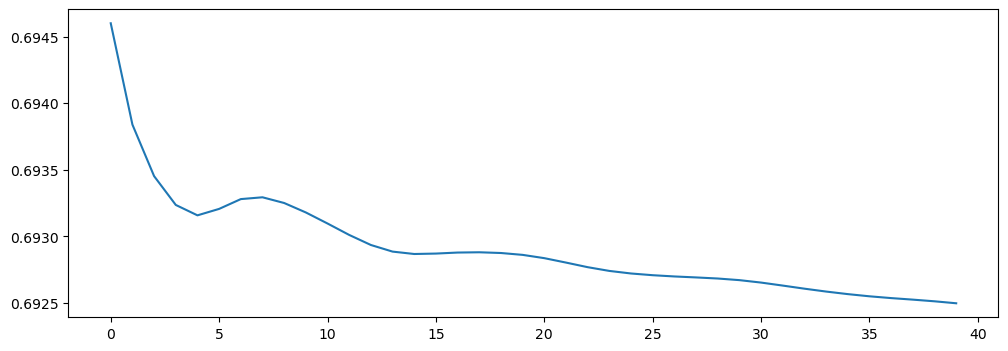

In [35]:
losses = []
for i in tqdm(range(40)):
    y_pred = network(x)
    loss = F.cross_entropy(y_pred, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

plt.figure(figsize=(12, 4))
plt.plot(range(40), losses)
plt.show()

### GPU support



In [36]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [37]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


Now let's create a tensor and push it to the device:

In [38]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]])


### From Lecture

**Activations**

In [39]:
# PRRELU
nn.LeakyReLU(0.5)
# ELU
nn.ELU(1)

ELU(alpha=1)

**[Weight Initialization](https://pytorch.org/docs/master/nn.init.html#torch.nn.init.xavier_normal_)**

In [40]:
l = nn.Linear(10, 2)
list(l.parameters())

[Parameter containing:
 tensor([[-0.0649,  0.0332,  0.0356, -0.0514, -0.2646, -0.2509, -0.1465,  0.1007,
          -0.0771,  0.3159],
         [-0.3103,  0.0524, -0.0374, -0.0874, -0.2678, -0.2098, -0.0589, -0.2174,
           0.1829,  0.0858]], requires_grad=True),
 Parameter containing:
 tensor([-0.1333,  0.0009], requires_grad=True)]

In [41]:
l.weight.data.normal_(0, 1)

tensor([[ 0.9754,  0.8633, -1.5324,  0.5753,  0.1026, -1.1606, -0.9770,  0.8285,
          1.4088, -1.2538],
        [-0.2677, -0.6127, -0.5573, -0.1157,  0.3607,  0.1477, -0.0243, -0.3138,
         -0.7777,  1.6378]])

In [42]:
list(l.parameters())

[Parameter containing:
 tensor([[ 0.9754,  0.8633, -1.5324,  0.5753,  0.1026, -1.1606, -0.9770,  0.8285,
           1.4088, -1.2538],
         [-0.2677, -0.6127, -0.5573, -0.1157,  0.3607,  0.1477, -0.0243, -0.3138,
          -0.7777,  1.6378]], requires_grad=True),
 Parameter containing:
 tensor([-0.1333,  0.0009], requires_grad=True)]

In [43]:
net = nn.Sequential(
    nn.Linear(4, 512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Sigmoid()
)

In [44]:
def _init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_normal_(module.weight.data)
        module.bias.data.zero_()

In [45]:
net.apply(_init_weights)

Sequential(
  (0): Linear(in_features=4, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): Sigmoid()
)

### LR scheduler

In [46]:
from torch.optim import lr_scheduler

  0%|          | 0/40 [00:00<?, ?it/s]

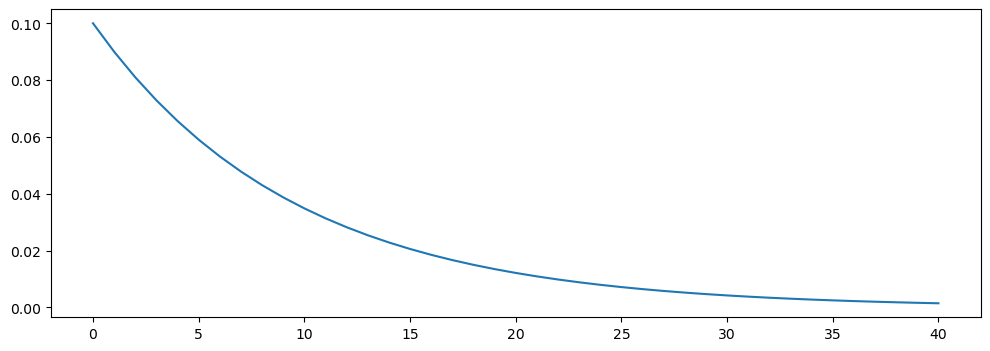

In [48]:
network = nn.Sequential(
    nn.Linear(4, 512),
    nn.ReLU(),
    nn.Linear(512, 2),
    nn.Sigmoid()
)
x = torch.randn(20000, 4)
y = torch.randint(2, size=(20000,))

optimizer = torch.optim.Adam(network.parameters(), lr=0.1)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

lrs = [optimizer.param_groups[0]['lr']]

for i in tqdm(range(40)):
    y_pred = network(x)
    loss = F.cross_entropy(y_pred, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    scheduler.step()
    lrs.append(optimizer.param_groups[0]['lr'])

plt.figure(figsize=(12, 4))
plt.plot(range(len(lrs)), lrs)
plt.show()


# for epoch in range(40):
#     for input, target in dataset:
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     scheduler.step()

### Regularization

In [49]:
nn.BatchNorm1d(num_features=32)  # nn.BatchNorm2d, nn.BatchNorm3d
nn.Dropout(0.5)

Dropout(p=0.5, inplace=False)

# Example : Classification

In [50]:
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, accuracy_score

In [51]:
def plot_data(x, y):
    plt.title(f'Data')
    sc = plt.scatter(x[:, 0], x[:, 1], s=1, c=y)
    if len(np.unique(y)) > 2:
        plt.colorbar(sc)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()

In [52]:
def make_torch_moons(n, noise=0.1):
    raw = make_moons(n, noise=noise)
    dataset = data.TensorDataset(torch.Tensor(raw[0]), torch.Tensor(raw[1]))
    return dataset

In [53]:
train_data = make_torch_moons(1000, noise=0.1)
test_data = make_torch_moons(500, noise=0.1)

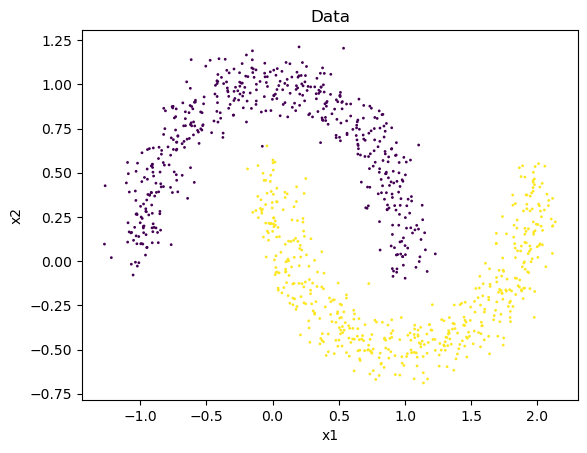

In [54]:
plot_data(train_data.tensors[0], train_data.tensors[1])

In [55]:
classifier = nn.Sequential(nn.Linear(2, 32),
                           nn.ReLU(),
                           nn.Linear(32, 32),
                           nn.ReLU(),
                           nn.Linear(32, 1),
                           nn.Sigmoid())

In [56]:
trainloader = data.DataLoader(train_data,
                              batch_size=128,
                              shuffle=True)

testloader = data.DataLoader(test_data,
                             batch_size=128)

In [57]:
optim = opt.Adam(classifier.parameters(), lr=1e-3)

In [58]:
def get_preds(model, dataloader):
    preds = np.array([])

    for (x, y) in dataloader:
        pred = model(x).detach().numpy().squeeze()
        preds = np.hstack((preds, pred))

    return preds

The classifiers can be trained on cross-entropy loss:

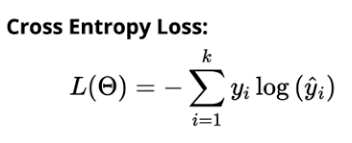

where $\Theta$ are weights of a neural network that we train, $y_i$ is a true label represented as one-hot binary vector, e.g. (0, 1, 0), and $\hat{y}_i$ are probabilities of belonging to classes, e.g. (0.1, 0.6, 0.3).

In [59]:
import torch.nn.functional as F

In [60]:
def train(model, optim, trainloader, testloader, num_epochs=100):
    aucs = []
    accs = []

    preds = get_preds(model, testloader)
    aucs.append(roc_auc_score(testloader.dataset.tensors[1], preds))
    accs.append(accuracy_score(testloader.dataset.tensors[1], preds.round()))

    for epoch in range(num_epochs):
        for (x, y) in trainloader:
            pred = model(x)  # forward
            loss = F.binary_cross_entropy(pred.squeeze(), y.float())

            optim.zero_grad()
            loss.backward()
            optim.step()

        preds = get_preds(model, testloader)
        aucs.append(roc_auc_score(testloader.dataset.tensors[1], preds))
        accs.append(accuracy_score(testloader.dataset.tensors[1], preds.round()))

    plt.plot(np.arange(num_epochs + 1), aucs)
    plt.xlabel('epoch')
    plt.ylabel('auc')
    plt.show()

    plt.plot(np.arange(num_epochs + 1), accs)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

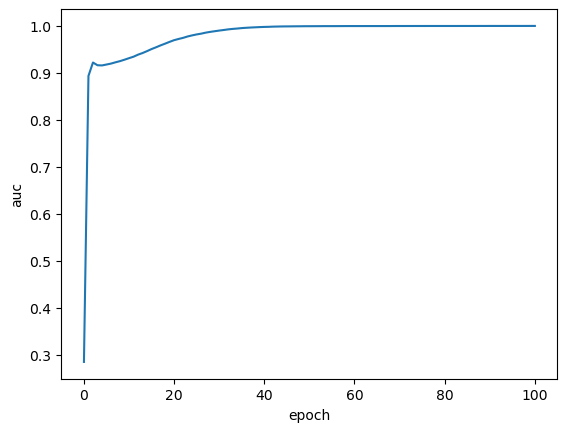

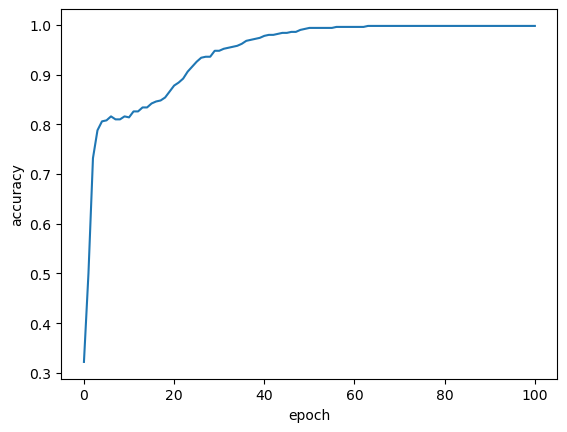

In [61]:
train(classifier, optim, trainloader, testloader, 100)

In [62]:
test_preds = get_preds(classifier, testloader)

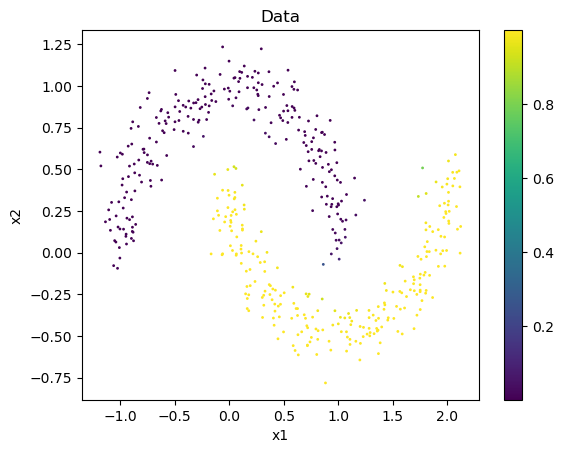

In [63]:
plot_data(test_data.tensors[0], test_preds)

In [64]:
x = torch.linspace(-1, 2, 100)
y = torch.linspace(-0.8, 1.3, 100)
grid = torch.meshgrid(x, y, indexing='ij')
grid = torch.vstack((grid[0].flatten(), grid[1].flatten()))
grid = grid.T

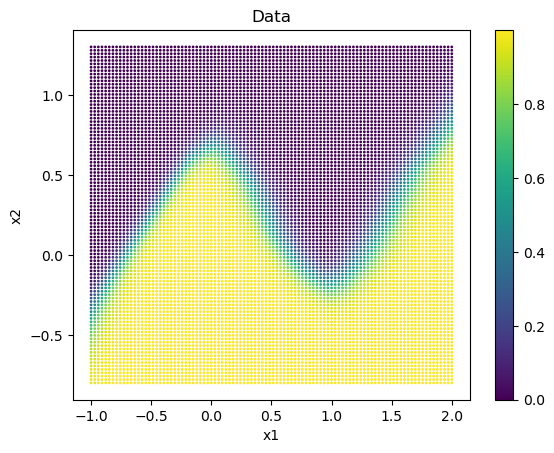

In [65]:
grid_preds = classifier(grid).detach().numpy()
plot_data(grid, grid_preds)

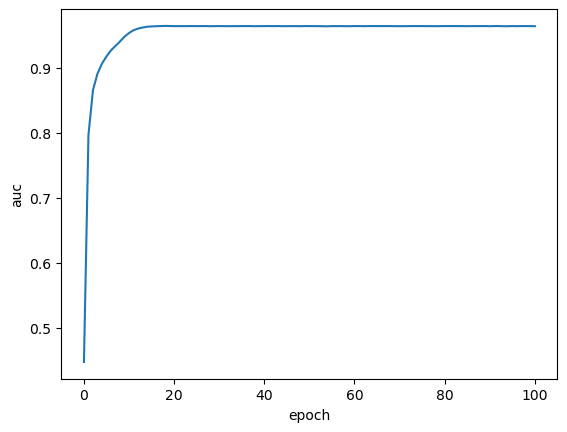

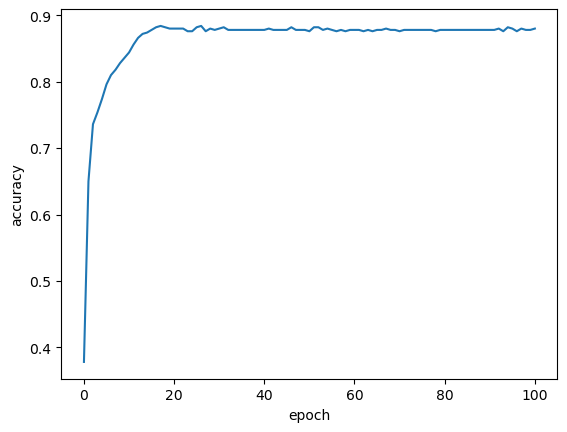

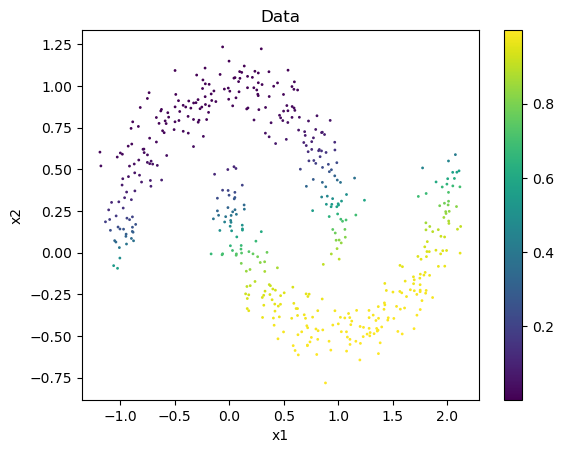

In [66]:
classifier = nn.Sequential(nn.Linear(2, 32),
                           nn.Linear(32, 32),
                           nn.Linear(32, 1),
                           nn.Sigmoid())

optim = opt.Adam(classifier.parameters(), lr=1e-3)
train(classifier, optim, trainloader, testloader)
test_preds = get_preds(classifier, testloader)
plot_data(test_data.tensors[0], test_preds)

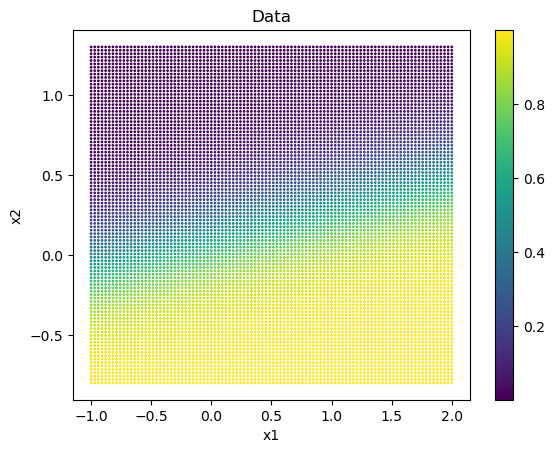

In [67]:
grid_preds = classifier(grid).detach().numpy()
plot_data(grid, grid_preds)

### Loss functions

either in [nn](https://pytorch.org/docs/stable/nn.html) or in [nn.functional](https://pytorch.org/docs/stable/nn.functional.html) 

In [68]:
loss_func = nn.CrossEntropyLoss()  # class

F.cross_entropy  # function
F.mse_loss
F.sigmoid

<function torch.nn.functional.sigmoid(input)>

# Exercise: Autoencoder 

Autoencoder is a special neural architecture that allows you to get compressed representations and many other cool things of data without labels. A typical autoencoder consists of an encoder and a decoder: the encoder transforms data into a hidden (latent) space (representation), and the decoder recovers the original data from the hidden space. The autoencoder is trained to reconstruct trainig images, i.e. the output of decoder should be similar to the input of encoder. This can be realized by training the model end-to-end on pixel-wise MSE loss:

$L_{ae} = \frac{1}{N_{pixels}} \sum_{pixels} (x_i - dec(enc(x))_i)^2$

where $x_i$ is a color of i-th pixel of an image (in practice, actual loss is also a sum over a batch of images, but I omitted it in the equation for brevity). Importantly, autoencoder cannot simply copy the input image, because the latent space is significantly smaller than the input space, so the image has to be compressed. This smaller latent space is called a bottleneck.

 The simplest usecase is to train the autoencoder to compress images into a smaller latent space (labels are not needed), and then use this latent representation (encoder output) as features for training a classifier/regressor/something else on our labeled data. A more interesting usecase is image generation by sampling new points in latent space, although good generation requires more complex architectures.

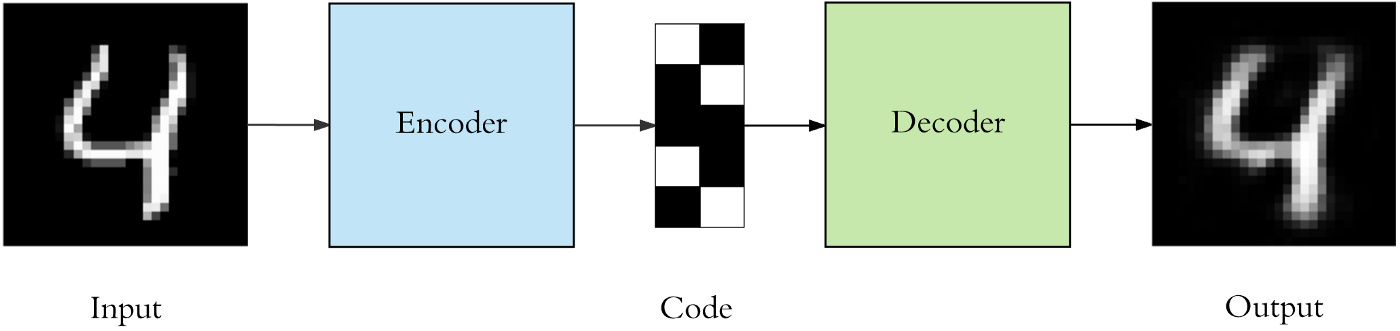

## utils

In [69]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [70]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: torch.flatten(x))
])

In [71]:
traindata = MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
testdata = MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [73]:
batch_size = 64

trainloader = DataLoader(
    dataset=traindata,
    batch_size=batch_size,
    shuffle=True
)
testloader = DataLoader(
    dataset=testdata,
    batch_size=batch_size,
    shuffle=False
)

In [74]:
@torch.no_grad()
def show_reconstruction(encoder, decoder, dataloader):
    x, _ = iter(dataloader).next()
    x = x[:10]

    x_rec = decoder(encoder(x))

    x = x.reshape(-1, 28, 28)
    x_rec = x_rec.reshape(-1, 28, 28)

    img = torch.cat((x, x_rec))
    img = img.unsqueeze(1)
    img = make_grid(img, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [75]:
def tensor_to_image(x):
    x = x.detach().cpu().numpy()
    x = x.transpose(1, 2, 0)
    x = (x + 1) / 2
    return x

In [76]:
def accuracy_test(model, dataloader):
    preds = []
    ys = []
    for (x, y) in dataloader:
        pred = model(x).detach().numpy().squeeze()
        preds.append(pred)
        ys.append(y)

    preds = np.vstack(preds)
    ys = np.hstack(ys)

    return accuracy_score(ys, np.argmax(preds, axis=1))

## tasks

**1.** Implement an autoencoder model. We will work with 28x28 flatten images of digits (784 dimensional vector). Your encoder should be a neural net with input dim=784 and output dim=128. For decoder, dimensions are swapped.

In [101]:
encoder = nn.Sequential(nn.Linear(784, 256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 128))  # make a net

decoder = nn.Sequential(nn.Linear(128, 128),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, 784))  # make a net

In [102]:
opt_enc = opt.Adam(encoder.parameters(), lr=1e-3)  # initialize an opt  imizer with encoder parameters
opt_dec = opt.Adam(decoder.parameters(), lr=1e-3)  # initialize an optimizer with decoder parameters

In [103]:
def train1(encoder, decoder, trainloader, opt_enc, opt_dec, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"==== EPOCH {epoch}")
        for (x, y) in trainloader:
            encoded_x = encoder(x)
            decoded_x = decoder(encoded_x)
            loss = F.mse_loss(decoded_x, x)

            opt_enc.zero_grad()
            opt_dec.zero_grad()

            loss.backward()

            opt_enc.step()
            opt_dec.step()


In [104]:
train1(encoder, decoder, trainloader, opt_enc, opt_dec, 5)

==== EPOCH 0
==== EPOCH 1
==== EPOCH 2
==== EPOCH 3
==== EPOCH 4


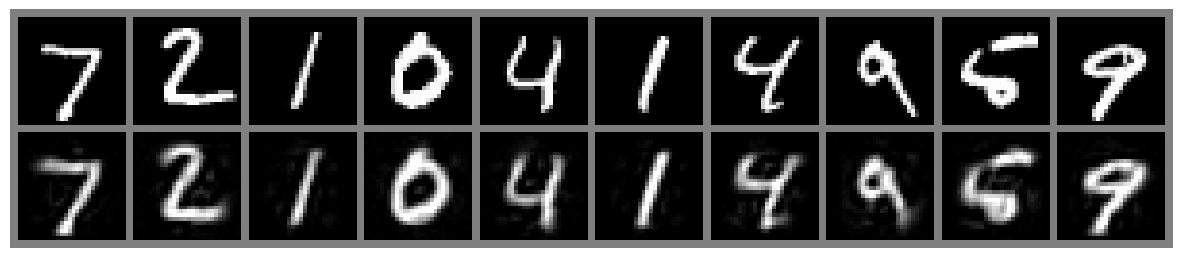

In [105]:
# run this cell to show quality of trained autoencoder
show_reconstruction(encoder, decoder, testloader)

**2.** Here we will train two classifiers on MNIST dataset.

First, lets make a classifier on initial data (data dimension is 784). Your model should output a 10 dimensional vector of probabilities (for each digit). Use nn.Softmax(dim=-1) as last layer in your model.

In [106]:
classifier = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(dim=-1)
)  # make a net

In [107]:
opt_clf = opt.Adam(classifier.parameters(), lr=1e-3)  # initialize an optimizer with classifier parameters

In [186]:
def train2(classifier, trainloader, opt_clf, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"==== EPOCH {epoch}")
        for (x, y) in trainloader:
            preds = classifier(x)
            # print(F.one_hot(y.to(torch.int64), num_classes=10))
            loss = F.cross_entropy(preds, F.one_hot(y.to(torch.int64), num_classes=10).float())

            opt_clf.zero_grad()

            loss.backward()

            opt_clf.step()

    # todo

In [135]:
train2(classifier, trainloader, opt_clf, 10)

==== EPOCH 0
==== EPOCH 1
==== EPOCH 2
==== EPOCH 3
==== EPOCH 4
==== EPOCH 5
==== EPOCH 6
==== EPOCH 7
==== EPOCH 8
==== EPOCH 9


In [136]:
# run this cell to calculate an accuracy
accuracy_test(classifier, testloader)

0.9568

Now, train a classifier on an encoded mnist data. For this implement a function that encodes data

In [170]:
def encode_data(encoder, dataloder, batch_size=batch_size, shuffle=True):
    new_x = torch.Tensor()
    new_y = torch.Tensor()
    for (x, y) in dataloder:
        encoded_x = encoder(x)
        new_x = torch.cat((new_x, encoder(x)), 0)
        new_y = torch.cat((new_y, y.int()), 0)
    # iterate over data to collect encoded images with their labels

    dataset = data.TensorDataset(new_x.detach(), new_y)  # new_x - encoded images, new_y - old labels of enocoded images
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [171]:
batch_size = 64
encoded_train_loader = encode_data(encoder, trainloader, batch_size, True)
encoded_test_loader = encode_data(encoder, testloader, batch_size, False)

In [172]:
classifier_e = nn.Sequential(
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Sigmoid()
) # make a net

In [173]:
opt_clf = opt.Adam(classifier_e.parameters(), lr=1e-3) # initialize an optimizer with classifier parameters

In [187]:
train2(classifier_e, encoded_train_loader, opt_clf, 10)

==== EPOCH 0
==== EPOCH 1
==== EPOCH 2
==== EPOCH 3
==== EPOCH 4
==== EPOCH 5
==== EPOCH 6
==== EPOCH 7
==== EPOCH 8
==== EPOCH 9


In [188]:
# run this cell to calculate an accuracy
accuracy_test(classifier_e, encoded_test_loader)

0.968

Compare results of both classifiers.

**3.** Train an encoder with additional L_2 penalty on encoded_x, i.e. add MSE from latent representation to 0 to the loss:

$L_{ae+l2} = L_{ae} + \lambda enc(x)^2$

This will penalize high values in the latent representation and make it more compact, which will be useful in task 4.

In [194]:
encoder_r = nn.Sequential(nn.Linear(784, 256),
                        nn.ReLU(),
                        nn.Linear(256, 128),
                        nn.ReLU(),
                        nn.Linear(128, 128))  # make a net

decoder_r = nn.Sequential(nn.Linear(128, 128),
                        nn.ReLU(),
                        nn.Linear(128, 256),
                        nn.ReLU(),
                        nn.Linear(256, 784))  # make a net

In [195]:
opt_enc = opt.Adam(encoder_r.parameters(), lr=1e-3)  # initialize an optimizer with encoder parameters
opt_dec = opt.Adam(decoder_r.parameters(), lr=1e-3)  # initialize an optimizer with decoder parameters

In [196]:
def train3(encoder, decoder, trainloader, opt_enc, opt_dec, lam=5, num_epochs=5):
    for epoch in range(num_epochs):
        print(f"==== EPOCH {epoch}")
        for (x, y) in trainloader:
            encoded_x = encoder(x)
            decoded_x = decoder(encoded_x)
            loss = F.mse_loss(decoded_x, x) + lam* (encoded_x ** 2).mean()

            opt_enc.zero_grad()
            opt_dec.zero_grad()

            loss.backward()

            opt_enc.step()
            opt_dec.step()

# todo

In [197]:
train3(encoder_r, decoder_r, trainloader, opt_enc, opt_dec, 1, 5)

==== EPOCH 0
==== EPOCH 1
==== EPOCH 2
==== EPOCH 3
==== EPOCH 4


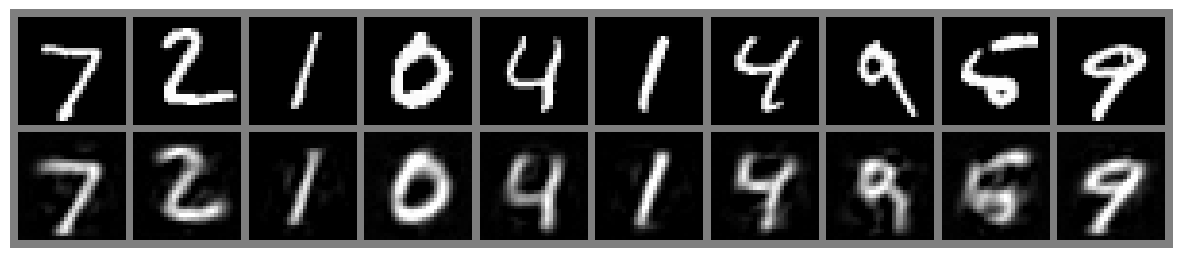

In [198]:
# run this cell to show quality of trained autoencoder
show_reconstruction(encoder_r, decoder_r, testloader)

**4.** Interpolate from one image to another by mixing latent representations of the two images.

In [267]:
def show_interpolation(dataloader, encode, decode):
    x, _ = iter(dataloader).next()
    x = x

    x1, x2 = x[:10], x[1:11]

    c1 = encode(x1) # encode x1
    c2 = encode(x2) # encode x2

    ks = np.linspace(0, 1, num=10)
    ks = torch.FloatTensor(ks)
    ks = ks.reshape((1, 10, *([1] * (len(c1.shape) - 1))))

    c1 = c1.unsqueeze(1)
    c2 = c2.unsqueeze(1)

    ks = ks.repeat(c1.shape)

    # c = ks * c1 + (1 - ks) * c2 # make a list of linear combinations of c1 and c2 with ks as weights
    c = ks * c1 + (1 - ks) * c2
    c = c.flatten(end_dim=1)
    img = decode(c) # decode c

    img = img.view(-1, 1, 28, 28)
    img = make_grid(img, nrow=10)
    img = tensor_to_image(img)
    img = img.clip(0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

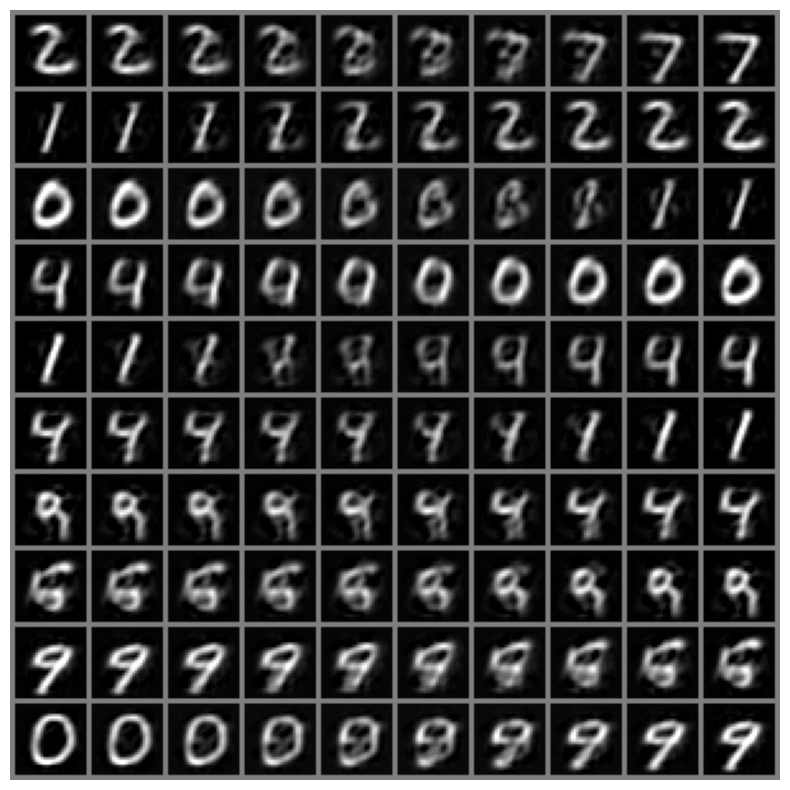

In [268]:
# show interpolation for encoder_r
show_interpolation(testloader, encoder_r, decoder_r)

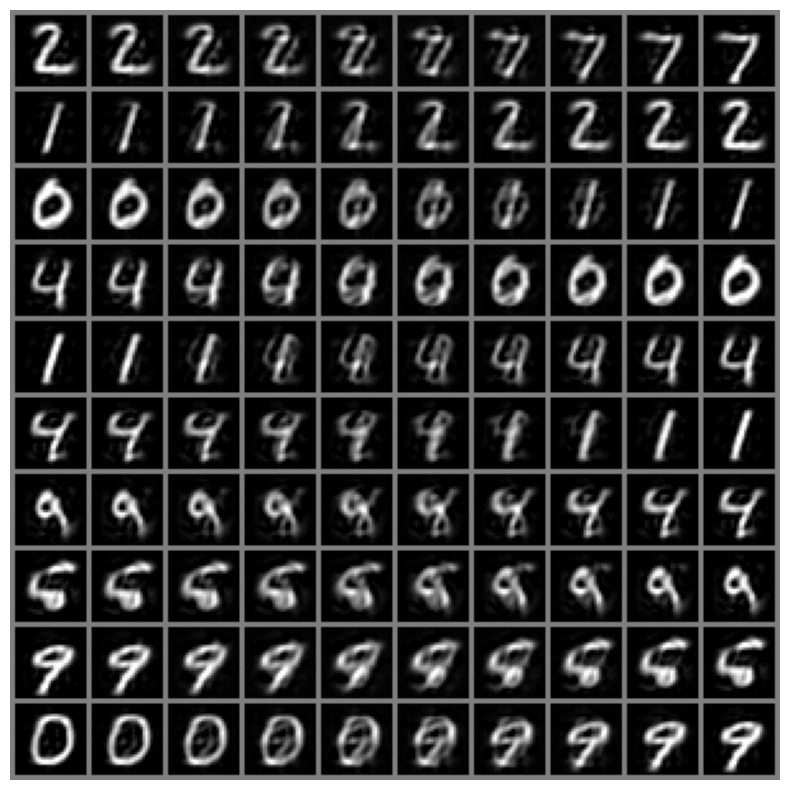

In [244]:
# show interpolation for encoder
show_interpolation(testloader, encoder, decoder)

What can you say about interpolations of encoder w/ and w/out regularization.